<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: application to optimization problems*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q experience (QX), consult the [IBM Q experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Antonio Mezzacapo, Jay Gambetta, Kristan Temme, Ramis Movassagh

## Introduction

Many problems in quantitative fields such as finance and engineering are optimization problems. Optimization problems lay at the core of complex decision-making and definition of strategies. 

Optimization or combinatorial optimization means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called cost function or objective function. 

**Typical optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects. 

We consider here two problems of practical interests in many fields, and show how they can mapped and soved on quantum computers.


### Weighted MaxCut:

MaxCut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given MaxCut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other's buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.

The formal definition of this problem is the following:

Consider a $n$-node non-directed graph *G(V, E)* where *|V| = n* with edge weights $w_{ij}>0$ for $(i, j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$ one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j)$$

In our simple marketing model, $w_{ij}$ represents the probability that the person $j$ will buy a product after $i$ gets a a free one. Note that the weights $w_{ij}$ can in principle be greater than $1$, corresponding to the case that the individual $j$ will buy more than one product. Maximizing the total buying probability corresponds to maximize the total future revenues. In the case the profit probability will be greater than the cost of the initial free samples, the strategy is a convenient one. An extension to this model has the nodes themselves carry weights, which can be regarded, in our marketing model, as the likelihood that a person granted with a free sample of the product will buy it again in the future. With this additional information on our model, the objective function to maximize becomes 

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j)+\sum_i w_i x_i. $$
 
In order to find a solution to this problem on a quantum computer, one needs first to map it to an Ising Hamiltonian. This can be done with the assignment $x_i\rightarrow (1-Z_i)/2$ where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$. Doing this we find that 

$$C(\textbf{Z}) = \sum_{i<j} \frac{w_{ij}}{2} (1-Z_i)(1+Z_j) + \sum_i w_i (1-Z_i)/2 = -\frac{1}{2}\left( \sum_{i<j} w_{ij} Z_iZ_j +\sum_i w_i Z_i\right)+\mathrm{const},$$

where const = $\sum_{i<j}w_{ij}/2+\sum_i w_i/2 $. In other terms, the weighted MaxCut problem is equivalent to minimizing the Ising Hamiltonian 

$$ H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j.$$

### Traveling Salesman Problem:

In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematician for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. Colloquially speaking, the traveling salesman is a person that goes from city to city to sell a merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started travelling. By doing this, the salesman gets to maximize its potential sales in the least amount of time. 

The problem derives its importance from its "hardness" and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.
 
The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of max-cut, best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest *Hamiltonian cycle* that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and p represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever non specified, the summands run over 0,1,...N-1)

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j) \notin E$ (not connected in the graph). The form of this penalty is 

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$ 

where it is assumed the boundary condition of the Hamiltonian cycle, $(p=N)\equiv (p=0)$. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

Putting this all together in a single objective function to be minimized we get the following

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ is a free parameter. One needs to ensure that A is large enough so that these constraints are respected. One way to do this is to choose A such that $A > \mathrm{max}(w_{ij})$. Furthermore, since the problem has the salesperson returning to the original city it is possible, without loss of generality, to set $x_{00} = 1$, $x_{i0} = 0 \; \forall i\neq 0$, and $x_{0p} = 0 \;\forall p\neq 0$. Doing this the objective functions becomes 

$$C(\textbf{x})=\sum_{i,j=1}^{N-1}w_{ij}\sum_{p=1}^{N-1} x_{i,p}x_{j,p+1}+\sum_{j=1}^{N-1}w_{0j} x_{j,1}+\sum_{i=1}^{N-1}w_{i0} x_{i,N-1}+ A\sum_{p=1}^{N-1}\left(1- \sum_{i=1}^{N-1} x_{i,p}\right)^2+A\sum_{i=1}^{N-1}\left(1- \sum_{p=1}^{N-1} x_{i,p}\right)^2.$$

Once again, it is easy to map the problem in this form to a quantum computer, and the solution will be found by minimizing a Ising Hamiltonian. 



### Approximate Universal Quantum Computing for Optimization Problems

There has been a considerable amount of interest in recent times about the use of quantum computers to find a solution to combinatorial problems. It is important to say that, given the classical nature of combinatorial problems, exponential speedup in using quantum computers compared to the best classical algorithms is not guaranteed. However, due to the nature and importance of the target problems, it is worth investigating heuristic approaches on a quantum computer that could indeed speed up some problem instances. Here it is shown a possible route for using quantum computers in this context, which we frame in the context of *approximate quantum computing*, given its heuristic nature. 

The Algorithm works as follows:
1. Choose the $w_i$ and $w_{ij}$ in the target Ising problem. In principle even higher powers of Z are allowed.
2. Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.
3. Choose a set of controls $\theta$ and make a trial function $|\psi(\theta)\rangle$.
4. Evaluate $C(\theta) = \langle\psi(\theta)~|H|~\psi(\theta)\rangle = \sum_i w_i \langle\psi(\theta)~|Z_i|~\psi(\theta)\rangle+ \sum_{i<j} w_{ij} \langle\psi(\theta)~|Z_iZ_j|~\psi(\theta)\rangle$ by sampling the outcome of the circuit and adding the expectation values together. In general different control points around $\theta$ have to be estimated, depending on the classical optimizer chosen. 
5. Use a classical optimizer to choose a new set of controls.
6. Continue until $C(\theta)$ reaches a minimum, close enough to the solution $\theta^*$.
7. Use $\theta^*$ to generate a final set of samples from the distribution $|\langle z_i~|\psi(\theta^*)\rangle|^2\;\forall i$, to obtain the answer.
    
It is our belief the difficulty of finding good heuristic algorithms will come down to the choice of an appropriate trial wavefunction. For example, one could consider a trial function whose entanglement best aligns with the target problem, or simply make the amount of entanglement a variable. In this tutorial we will consider a simple trial function of the form

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates (fully entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of quantum states that have only real coefficients, still exploiting the entanglement to potentially converge faster to the solution.

One advantage of using this sampling method compared to adiabatic approaches is that the target Ising Hamiltonian does not have to be implemented directly on hardware, allowing this algorithm no to be limited to the connectivity of the device. Furthermore, higher orders terms in the cost function, such as $Z_iZ_jZ_k$, can also be sampled efficiently, whereas in adiabatic or annealing approaches they are generally impractical to deal with. 


References:
- A. Lucas, Frontiers in Physics 2, 5 (2014)
- E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028 (2014)

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial
import networkx as nx

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_ry, SPSA_optimization, SPSA_calibration
from tools.optimizationtools import Energy_Estimate, make_Hamiltonian
from tools.pauli import Pauli

In [2]:
def obj_funct(Q_program, pauli_list, n, m, device, shots, theta):
    """ Evaluate the objective function for a classical optimization problem.

    Q_program is an instance object of the class quantum program
    pauli_list defines the cost function as list of ising terms with weights
    theta are the control parameters 
    n is the number of qubits
    m is the depth of the trial function 
    device is the type of backend to run it on
    shots is the number of shots to run. Taking shots = 1 only works in simulation
    and computes an exact average of the cost function on the quantum state
    """
    std_cost=0 # to add later
    circuits = ["trial_circuit"] 
   
        
    if shots==1:  
        Q_program.add_circuit("trial_circuit", trial_circuit_ry(n, m, theta, entangler_map,None,False))
        Q_program.execute(circuits, device, shots)
        state = Q_program.get_data("trial_circuit")['quantum_state']
        H = pauli_list
        cost = (np.inner(np.conjugate(state),np.dot(H,state))).real   
    else:
        Q_program.add_circuit("trial_circuit", trial_circuit_ry(n, m, theta, entangler_map,None,True))
        Q_program.execute(circuits, device, shots)
        data = Q_program.get_counts("trial_circuit")
        cost = Energy_Estimate(data, pauli_list)
       
    
    return cost, std_cost

## MaxCut on 4 Qubits

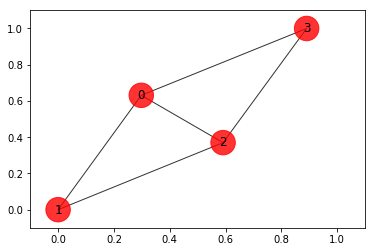

In [72]:
# Generating a graph of 4 nodes 

n =4 # Number of nodes in graph

G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
default_axes.set_xlim(-0.1,1.1)
default_axes.set_ylim(-0.1,1.1)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8,ax=default_axes)


In [73]:
# Computing the weight matrix from the random graph

w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 

In [74]:
print(w)

[[ 0.  1.  1.  1.]
 [ 1.  0.  1.  0.]
 [ 1.  1.  0.  1.]
 [ 1.  0.  1.  0.]]


### Brute force approach

Try all possible $2^n$ combinations. For $n = 4$ as in this example one deals with only 16 combinations, but for n = 1000 one has 1.071509e+30 combinations, which is impractical to deal with by using a brute force approach. 

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


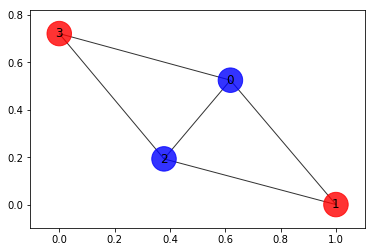

In [75]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    
    print("case = " + str(x)+ " cost = " + str(cost))

colors = []
for i in range(n):
    if xbest_brute[i] == 0:
        colors.append('r')
    else:
        colors.append('b')
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8)
#plt.show()
print("\nBest solution = " +str(xbest_brute)+ " cost = " + str(best_cost_brute))    

### Mapping to the Ising problem

In [91]:
# Determining the constant shift and initialize a pauli_list that contains the ZZ Ising terms

pauli_list = []
cost_shift = 0
for i in range(n):
        for j in range(i):
            if w[i,j] != 0:
                cost_shift = cost_shift + w[i,j]
                wp = np.zeros(n)
                vp = np.zeros(n)
                vp[i] = 1
                vp[j] = 1
                pauli_list.append((w[i,j],Pauli(vp,wp)))
cost_shift

5.0

### Checking that the full Hamiltonian gives the right cost 

In [92]:
#Making the Hamiltonian in its full form and get the lowest eigenvalue and eigenvector

H = make_Hamiltonian(pauli_list)
we, ve = la.eigh(H, eigvals=(0, 1))
exact = we[0]
exact_maxcut = -we[0]/2+cost_shift/2
print(exact_maxcut)
print(exact)

4.0
-3.0


### Running it on quantum computer

We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$

In [81]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

True

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 0.255830020651
SPSA parameters = [ 0.25583002  0.1         0.602       0.101       0.        ]
objective function at theta+ for step # 0
0.94
objective function at theta- for step # 0
1.1
objective function at theta+ for step # 20
-2.08
objective function at theta- for step # 20
-1.96
objective function at theta+ for step # 40
-2.58
objective function at theta- for step # 40
-2.56
objective function at theta+ for step # 60
-2.64
objective function at theta- for step # 60
-2.56
objective function at theta+ for step # 80
-2.68
objective function at theta- for step # 80
-2.8
Final objective function is: -2.86


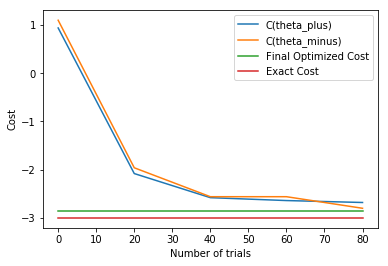

In [83]:
# Testing Optimization on a quantum computer 

# Quantum circuit parameters:

# the entangler step is made of two-qubit gates between a control and target qubit, control: [target]
entangler_map = {0: [1], 1: [2], 2: [3]} 
# the backend used for the quantum computation
device = 'local_qasm_simulator' 
# Total number of trial steps used in the optimization
max_trials = 100; 
n = 4 # the number of qubits 
# Depth of the quantum circuit that prepares the trial state
m = 3     
# initial starting point for the control angles
initial_theta=np.random.randn(m*n)   
# number of shots for each evaluation of the cost function (shots=1 corresponds to perfect evaluation, 
# only available on the simulator)
shots = 100
# choose to plot the results of the optimizations every save_steps 
save_step = 20


""" ##########################      RUN    OPTIMIZATION      #######################"""

if shots == 1:
    obj_funct_partial = partial(obj_funct, Q_program, H, n, m, device, shots)
    initial_c=0.01
else:
    obj_funct_partial = partial(obj_funct, Q_program, pauli_list, n, m, device, shots)
    initial_c=0.1

target_update=2*np.pi*0.1
SPSA_parameters=SPSA_calibration(obj_funct_partial,initial_theta,initial_c,target_update,25)
print ("SPSA parameters = " + str(SPSA_parameters))

best_distance_quantum, best_theta, cost_plus, cost_minus,_,_ = SPSA_optimization(obj_funct_partial, initial_theta, SPSA_parameters, max_trials, save_step)

plt.plot(np.arange(0, max_trials,save_step),cost_plus,label='C(theta_plus)')
plt.plot(np.arange(0, max_trials,save_step),cost_minus,label='C(theta_minus)')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*best_distance_quantum, label='Final Optimized Cost')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*exact, label='Exact Cost')
plt.legend()
plt.xlabel('Number of trials')
plt.ylabel('Cost')

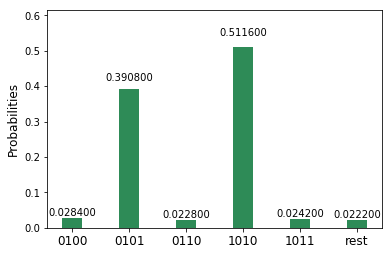

In [84]:
shots = 5000
circuits = ["final_circuit"]   
Q_program.add_circuit("final_circuit", trial_circuit_ry(n, m, best_theta, entangler_map,None,True))
Q_program.execute(circuits, device, shots)
data = Q_program.get_counts("final_circuit")
plot_histogram(data,5)

Best solution from the quantum optimization is = [ 1.  0.  1.  0.] with cost = 4.0


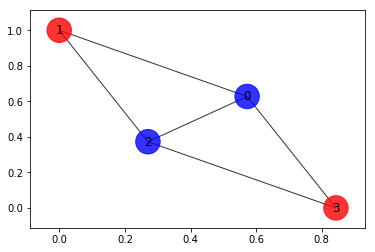

In [98]:
# Getting the solution and cost from the largest component of the optimal quantum state

max_value = max(data.values())  # maximum value
max_keys = [k for k, v in data.items() if v == max_value] # getting all keys containing the `maximum`

x_quantum=np.zeros(n)
for bit in range(n):
    if max_keys[0][bit]=='1':
        x_quantum[bit]=1
        
best_cost_quantum = 0
for i in range(n):
    for j in range(n):
        best_cost_quantum+= w[i,j]*x_quantum[i]*(1-x_quantum[j])
        
        
# Plot the quantum solution
colors = []
for i in range(n):
    if x_quantum[i] == 0:
        colors.append('r')
    else:
        colors.append('b')
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8)

print("Best solution from the quantum optimization is = " +str(x_quantum)+ " with cost = " + str(best_cost_quantum))    

## Traveling Salesman for 4 cities (9 qubits)

For the second problem we consider the traveling salesman problem on N=4 cities. In this case there are (N-1)! two different combinations.

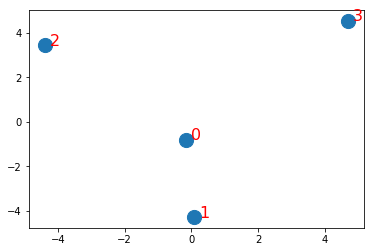

In [25]:
# Random choice of the cities/nodes 
N = 4
xc = (np.random.rand(N)-0.5)*10
yc = (np.random.rand(N)-0.5)*10

plt.scatter(xc, yc, s=200)
for i in range(len(xc)):
    plt.annotate(i,(xc[i]+0.15,yc[i]),size=16,color='r')
plt.show()

In [26]:
# Getting the distances 
w = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        w[i,j]= np.sqrt((xc[i]-xc[j])**2+(yc[i]-yc[j])**2)

### Brute force approach

The brute force approach consists in trying all the paths given by all the permutations of cities/nodes. The number of permutations of N cities/nodes is (N-1)! which gives for 

N = 4 # paths = 6

N = 8 # paths = 5040

N = 16 # paths = 1.3076744e+12

order = (0, 1, 2, 3) Distance = 28.7476810136
order = (0, 1, 3, 2) Distance = 28.5739775569
order = (0, 2, 1, 3) Distance = 32.0883815603
order = (0, 2, 3, 1) Distance = 28.5739775569
order = (0, 3, 1, 2) Distance = 32.0883815603
order = (0, 3, 2, 1) Distance = 28.7476810136


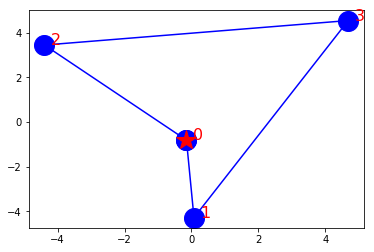

Best order from brute force = (0, 1, 3, 2) with total distance = 28.5739775569


In [28]:
a=list(permutations(range(1,N)))
last_best_distance = 10000000
for i in a:
    distance = 0 
    pre_j = 0
    for j in i:
        distance = distance + w[j,pre_j]
        pre_j = j
    distance = distance + w[0,pre_j]
    order = (0,) + i
    if distance < last_best_distance:
        best_order = order
        last_best_distance = distance
    print("order = " + str(order) + " Distance = " + str(distance))

best_distance_brute = last_best_distance
best_order_brute = best_order

plt.scatter(xc, yc)
xbest = np.array([xc[i] for i in best_order_brute])
xbest=np.append(xbest,xbest[0])
ybest = np.array([yc[i] for i in best_order_brute])
ybest=np.append(ybest,ybest[0])
plt.plot(xbest, ybest, 'b.-', ms = 40)
plt.plot(xc[0], yc[0], 'r*', ms = 20)
for i in range(len(xc)):
    plt.annotate(i,(xc[i]+0.2,yc[i]),size=16,color='r')
plt.show()
print("Best order from brute force = " + str(best_order_brute) + " with total distance = " + str(best_distance_brute))

### Mapping to binary variables and simulated annealing 

Recall from the introduction that the cost function of the TSP mapped to binary variables is of the form:

$$C(\textbf{x})=\sum_{i,j=1}^{N-1}w_{ij}\sum_{p=1}^{N-1} x_{i,p}x_{j,p+1}+\sum_{j=1}^{N-1}w_{0j} x_{j,1}+\sum_{i=1}^{N-1}w_{i0} x_{i,N-1}+ A\sum_{p=1}^{N-1}\left(1- \sum_{i=1}^{N-1} x_{i,p}\right)^2+A\sum_{i=1}^{N-1}\left(1- \sum_{p=1}^{N-1} x_{i,p}\right)^2.$$

In [29]:
n=(N-1)**2 # number of qubits
A = np.max(w)*100 # A parameter of cost function

# takes the part of w matrix excluding the 0-th point, which is the starting one 
wsave = w[1:N,1:N]
# nearest neighbor interaction matrix for the prospective cycle (p,p+1 interaction)
shift = np.zeros([N-1,N-1])
shift = la.toeplitz([0,1,0], [0,1,0])/2

# the first and last point of the TSP problem are fixed by initial and final conditions 
firststep = np.zeros([N-1])
firststep[0] = 1;
laststep = np.zeros([N-1])
laststep[N-2] = 1;

# The binary variables that define a path live in a tensor product space of position and ordering indices

# Q defines the interactions between variables 
Q = np.kron(shift,wsave) + np.kron(A*np.ones((N-1, N-1)), np.identity(N-1)) + np.kron(np.identity(N-1),A*np.ones((N-1, N-1)))
# G defines the contribution from the individual variables 
G = np.kron(firststep,w[0,1:N]) + np.kron(laststep,w[1:N,0]) - 4*A*np.kron(np.ones(N-1),np.ones(N-1))
# M is the constant offset 
M = 2*A*(N-1)

# Evaluates the cost distance from a binary representation of a path 
fun = lambda x: np.dot(np.around(x),np.dot(Q,np.around(x)))+np.dot(G,np.around(x))+M

def get_order_tsp(x):
    # This function takes in a TSP state, an array of (N-1)^2 binary variables, and returns the 
    # corresponding travelling path associated to it 
    order = [0]
    for p in range(N-1):
        for j in range(N-1):
            if x[(N-1)*j+p]==1:
                order.append(j+1)
    return order

def get_x_tsp(order):
    # This function takes in a travelling path and returns a TSP state, in the form of an array of (N-1)^2 
    # binary variables 
    x = np.zeros((len(order)-1)**2)
    for j in range(1,len(order)):
        p=order[j]
        x[(N-1)*(j-1)+(p-1)]=1
    return x


In [44]:
# Checking if the best results from the brute force approach are correct for the mapped system of binary variables

# Conversion from a path to a binary variable array
xopt_brute =get_x_tsp(best_order_brute)

print('Best path from brute force mapped to binary variables: \n')
print(xopt)

flag=False
for i in range(100000):
    rd =  np.random.randint(2, size=n)
    if fun(rd) < (best_distance_brute-0.0001):
        print('\n A random solution is better than the brute-force one. The path measures')
        print(fun(rd))
        flag=True

if flag==False:
    print('\nCheck with 10^5 random solutions: the brute-force solution mapped to binary variables is correct.\n')
    
print('Shortest path evaluated with binary variables: ')
print(fun(xopt_brute))

Best path from brute force mapped to binary variables: 

[ 1.  0.  0.  0.  0.  1.  0.  1.  0.]

Check with 10^5 random solutions: the brute-force solution mapped to binary variables is correct.

Shortest path evaluated with binary variables: 
28.5739775569


distance = 28.5739775569 x_solution = [1 0 0 0 0 1 0 1 0], final temperature= 0.00045173345977048254


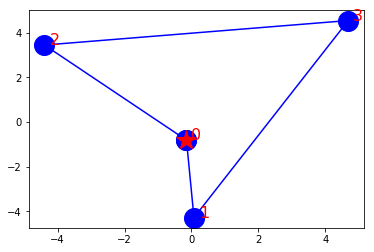

Best order from simulated annealing = [0, 1, 3, 2] with total distance = 28.5739775569


In [32]:
# Optimization with simulated annealing 

initial_x = np.random.randint(2, size=n)

cost = fun(initial_x)
x = np.copy(initial_x)
alpha = 0.999
temp = 10
for j in range(10000):
    
    # pick a random index and flip the bit associated to it  
    flip=np.random.randint(len(x))
    new_x = np.copy(x)
    new_x[flip]=(x[flip]+1)%2
    
    # compute cost function with flipped bit 
    new_cost=fun(new_x)
    if np.exp(-(new_cost-cost)/temp) > np.random.rand():
        x = np.copy(new_x)
        cost = new_cost
    temp= temp*alpha
print("distance = " + str(cost) + " x_solution = " + str(x) + ", final temperature= " + str(temp))

best_order_sim_ann=get_order_tsp(x)

plt.scatter(xc, yc)
xbest = np.array([xc[i] for i in best_order_sim_ann])
xbest=np.append(xbest,xbest[0])
ybest = np.array([yc[i] for i in best_order_sim_ann])
ybest=np.append(ybest,ybest[0])
plt.plot(xbest, ybest, 'b.-', ms = 40)
plt.plot(xc[0], yc[0], 'r*', ms = 20)
for i in range(len(xc)):
    plt.annotate(i,(xc[i]+0.15,yc[i]),size=16,color='r')
plt.show()
print("Best order from simulated annealing = " + str(best_order_sim_ann) + " with total distance = " + str(cost))

### Mapping to Z variables and simulation on a quantum computer

In [33]:
# Defining the new matrices in the Z basis 

Iv=np.ones((N-1)**2)
Qz = (Q/4)
Gz =( -G/2-np.dot(Iv,Q/4)-np.dot(Q/4,Iv))
Mz = (M+np.dot(G/2,Iv)+np.dot(Iv,np.dot(Q/4,Iv)))

Mz = Mz + np.trace(Qz)
Qz = Qz - np.diag(np.diag(Qz))

# Recall the change of variables is 
# x = (1-z)/2
# z = -2x+1
z= -(2*xopt)+Iv

for i in range(1000):
    rd =  1-2*np.random.randint(2, size=n)
    if np.dot(rd,np.dot(Qz,rd))+np.dot(Gz,rd)+Mz < (best_distance_brute-0.0001):
        print(np.dot(rd,np.dot(Qz,rd))+np.dot(Gz,rd)+Mz)

In [34]:
# Getting the Hamiltonian in the form of a list of Pauli terms 

pauli_list = []
for i in range(n):
    if Gz[i] != 0:
        wp = np.zeros(n)
        vp = np.zeros(n)
        vp[i] = 1
        pauli_list.append((Gz[i],Pauli(vp,wp)))
for i in range(n):
    for j in range(i):
        if Qz[i,j] != 0:
            wp = np.zeros(n)
            vp = np.zeros(n)
            vp[i] = 1
            vp[j] = 1
            pauli_list.append((2*Qz[i,j],Pauli(vp,wp)))
            
pauli_list.append((Mz,Pauli(np.zeros(n),np.zeros(n))))

In [35]:
# Making the Hamiltonian as a full matrix and find its lowest eigenvalue

H = make_Hamiltonian(pauli_list)
we, v = la.eigh(H, eigvals=(0,0))
exact = we[0]
print(exact)

28.5739775569


In [36]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

True

calibration step # 0 of 25
calibration step # 5 of 25
calibration step # 10 of 25
calibration step # 15 of 25
calibration step # 20 of 25
calibrated SPSA_parameters[0] is 0.000229771614478
SPSA parameters = [  2.29771614e-04   1.00000000e-02   6.02000000e-01   1.01000000e-01
   0.00000000e+00]
objective function at theta+ for step # 0
6550.69225642
objective function at theta- for step # 0
6569.74522702
objective function at theta+ for step # 20
2706.73673655
objective function at theta- for step # 20
2685.60500826
objective function at theta+ for step # 40
1962.73889175
objective function at theta- for step # 40
1928.83523259
objective function at theta+ for step # 60
1555.61312107
objective function at theta- for step # 60
1546.49935922
objective function at theta+ for step # 80
800.717449089
objective function at theta- for step # 80
791.695547375
objective function at theta+ for step # 100
623.6638888
objective function at theta- for step # 100
620.653493889
objective function at t

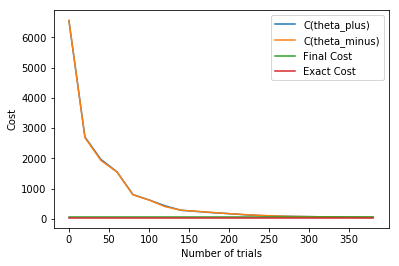

In [48]:
# Optimization of the TSP using a quantum computer 

# Quantum circuit parameters

# the entangler step is made of two-qubit gates between a control and target qubit, control: [target]
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8]}
# the backend used for the quantum computation
device = 'local_qasm_simulator' 
# Total number of trial steps used in the optimization
max_trials = 400; 
n = 9 # the number of qubits 
# Depth of the quantum circuit that prepares the trial state
m = 3     
# initial starting point for the control angles
initial_theta=np.random.randn(m*n)   
# number of shots for each evaluation of the cost function (shots=1 corresponds to perfect evaluation, 
# only available on the simulator)
shots = 1
# choose to plot the results of the optimizations every save_steps 
save_step = 20



""" ##########################      RUN OPTIMIZATION      #######################"""

if shots == 1:
    obj_funct_partial = partial(obj_funct, Q_program, H, n, m, device, shots)
    initial_c=0.01
else:
    obj_funct_partial = partial(obj_funct, Q_program, pauli_list, n, m, device, shots)
    initial_c=0.1


target_update=2*np.pi*0.1
SPSA_parameters=SPSA_calibration(obj_funct_partial,initial_theta,initial_c,target_update,25)
print ("SPSA parameters = " + str(SPSA_parameters))    
    
best_distance_quantum, best_theta, cost_plus, cost_minus,_,_ = SPSA_optimization(obj_funct_partial, initial_theta, SPSA_parameters, max_trials, save_step)


""" ##########################       PLOT RESULTS         #######################"""

plt.plot(np.arange(0, max_trials,save_step),cost_plus,label='C(theta_plus)')
plt.plot(np.arange(0, max_trials,save_step),cost_minus,label='C(theta_minus)')
plt.plot(np.arange(0, max_trials,save_step),(np.ones(max_trials//save_step)*best_distance_quantum), label='Final Cost')
plt.plot(np.arange(0, max_trials,save_step),np.ones(max_trials//save_step)*exact, label='Exact Cost')
plt.legend()
plt.xlabel('Number of trials')
plt.ylabel('Cost')

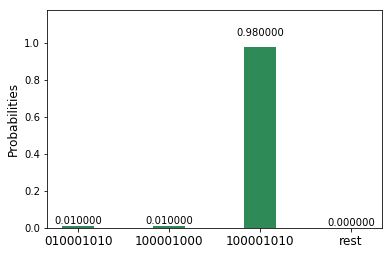

In [49]:
# Sampling from the quantum state generated with the optimal angles from the quantum optimization

shots = 100
circuits = ["final_circuit"]   
Q_program.add_circuit("final_circuit", trial_circuit_ry(n, m, best_theta, entangler_map,None,True))
Q_program.execute(circuits, device, shots)
data = Q_program.get_counts("final_circuit")
plot_histogram(data,5)

In [70]:
# Getting path and total distance from the largest component of the quantum state

max_value = max(data.values())  # maximum value
max_keys = [k for k, v in data.items() if v == max_value] # getting all keys containing the `maximum`

x_quantum=np.zeros(n)
for bit in range(n):
    if max_keys[0][bit]=='1':
        x_quantum[bit]=1
    
quantum_order = get_order_tsp(list(map(int, x_quantum)))
best_distance_quantum_amp=fun(x_quantum)

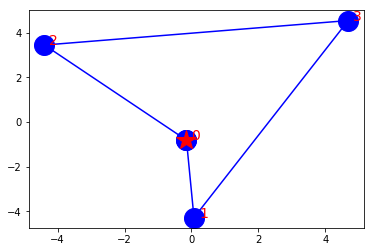

Best order from quantum optimization is = [0, 1, 3, 2] with total distance = 28.5739775569


In [71]:
plt.scatter(xc, yc)
xbest = np.array([xc[i] for i in quantum_order])
xbest = np.append(xbest,xbest[0])
ybest = np.array([yc[i] for i in quantum_order])
ybest = np.append(ybest,ybest[0])
plt.plot(xbest, ybest, 'b.-', ms = 40)
plt.plot(xc[0], yc[0], 'r*', ms = 20)
for i in range(len(xc)):
    plt.annotate(i,(xc[i]+0.15,yc[i]),size=14,color='r')
plt.show()
print("Best order from quantum optimization is = " + str(quantum_order) + " with total distance = " + str(best_distance_quantum_amp))